In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
data = pd.read_csv('data/train.csv')

print('data({0[0]},{0[1]})'.format(data.shape))
print(data.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

In [3]:
# ignore the label and flatten the pixels 
images = data.iloc[:,1:].values
images = images.astype(np.float)

# we want to normalize the pixel values
# [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0 )

print('images({0[0]},{0[1]})'.format(images.shape))


images(42000,784)


### images of 784 pixels, 28 * 28

In [4]:
image_size = images.shape[1]
print('image size => {0}'.format(image_size))

img_wdth = img_height = np.sqrt(image_size).astype(np.uint8)

print(img_wdth)
print(img_height)

image size => 784
28
28


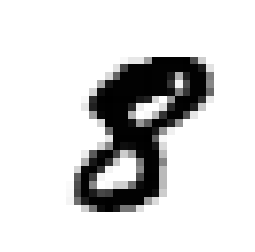

In [5]:
# to see an image, convert flattened array into 28 * 28 image

def display(img):
    # (784) => 28 * 28
    new_img = img.reshape(img_wdth, img_height)
    
    plt.axis('off')
    plt.imshow(new_img, cmap=cm.binary)
    plt.show()

display(images[10])

#### The labels provided are values for the digit in the image, 0-9 

In [6]:
labels = data[[0]].values.ravel()
print('labels({0})'.format(len(labels)))
print(labels)

labels(42000)
[1 0 1 ..., 7 6 9]


In [7]:
labels_cnt = np.unique(labels).shape[0]
print('labels count ({0})'.format(labels_cnt))

labels count (10)


we are going to use one-hot vectors, just an array of class values with the correct one as a 1 and the rest 0

an example for a one hot vector of the digit 8

[0 0 0 0 0 0 0 0 1 0]

In [8]:
# convert from scalar class label to one hot vector
def conv_to_onehot(dense_labels, num_class):
    num_labels = dense_labels.shape[0]
    indx_offset = np.arange(num_labels) * num_class
    labels_onehot = np.zeros((num_labels, num_class))
    labels_onehot.flat[indx_offset + dense_labels.ravel()] = 1
    return labels_onehot

labels = conv_to_onehot(labels, labels_cnt)
labels = labels.astype(np.uint8)

print(labels.shape)
print(labels[10])

(42000, 10)
[0 0 0 0 0 0 0 0 1 0]


In [9]:
# now split into training and validation data
VALIDATION_SIZE = 2000

validation_img = images[:VALIDATION_SIZE]
validation_lbls = labels[:VALIDATION_SIZE]

training_img = images[VALIDATION_SIZE:]
training_lbls = labels[VALIDATION_SIZE:]

print('train images: ({0[0]},{0[1]})'.format(training_img.shape))
print('validation images: ({0[0]}, {0[1]})'.format(validation_img.shape))

train images: (40000,784)
validation images: (2000, 784)


# Tensorflow Convolutional Neural Net

Now that the data is prepared, we can design the CNN

First, make some helper functions to make the NN easier to work with

### Helper functions

We will be using ReLU for our neurons, so it is good to init with a slightly positive value for the weights so that we do not get dead neurons 

Also want to include some noise in the initial weights for symmetry breaking, and to prevent 0 gradient values

In [10]:
def weight_variable(shape):
    init = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init)
def bias_variable(shape):
    init = tf.constant(0.1, shape=shape)
    return tf.Variable(init)

For information about CNN: https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional_layer

In [11]:
# convolution 
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

Pooling of plain max pooling over 2x2 blocks

In [12]:
# pooling

#[[0,2],
#[0,3]] => 3

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

The shape of this Convolutional NN will be 2 convolutional layers with pooling in between, then a densely connected layer, followed by dropout and the readout layer to classify. Readout layer will just use simple softmax 

In [13]:
# input & output 

# images
x = tf.placeholder('float', shape=[None, image_size])

# labels
y_ = tf.placeholder('float', shape=[None, labels_cnt])

First layer is convolution with max pooling. computes 32 features from each 5 by 5 patch. Weight tensor is [5, 5, 1, 32]. 5 by 5 patch size, number of input channels (we use 1 because the images are greyscale), and number of output channels 

To apply layer, reshape image data into 4d tensor, with [number images, height, width, output channels] (1 for greyscale)

after convolution, pooling reduces image to 28x28 to 14x14


In [14]:
# First layer
W_conv1 = weight_variable([5, 5, 1, 32]) # helper function here to properly init these weight values
b_conv1 = bias_variable([32])

# images(4000, 784) => (4000, 28, 28, 1)
image = tf.reshape(x, [-1, img_wdth, img_height, 1])
# print (image.get_shape())

h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1) # relu allows us to adjust loss as we train
# print(h_conv1.get_shape())

h_pool1 = max_pool_2x2(h_conv1)
# print(h_pool1.get_shape())

# prepare for visualization

# 32 features in 4 x 8 grid
layer1 = tf.reshape(h_conv1, (-1, img_height, img_wdth, 4, 8))
# print(layer1.get_shape())

# reorder so channels in first dimension, x and y follow
layer1 = tf.transpose(layer1, (0, 3, 1, 4, 2))
# print(layer1.get_shape())

layer1 = tf.reshape(layer1, (-1, img_height * 4, img_wdth * 8))
# print(layer1.get_shape())

Second layer has 64 features for each 5x5 patch. Its weight tensor is shaped: [5, 5, 32, 64]
    
32 input channels from previous layer, 64 for our output

Since the pooling has reduced to 14 x 14, this layer picks up more of the general features 

In [15]:
# second layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# print(h_conv2.get_shape())
# (4000, 14, 14, 64)

h_pool2 = max_pool_2x2(h_conv2)

# Prepare visualization
# display 64 features in 4 * 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4, 6))

# reorder so channels are in the first column, x and y follow
layer2 = tf.transpose(layer2, (0, 3, 1, 4, 2))

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16))

 Image size reduced to 7 x 7, here we add fully connected layer

In [16]:
# dense connected layer 
W_fcl = weight_variable([7 * 7 * 64, 1024])
b_fcl = bias_variable([1024])

# (?, 7, 7, 64) =? (?, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fcl = tf.nn.relu(tf.matmul(h_pool2_flat, W_fcl) + b_fcl)
# print(h_fcl.get_shape())
# (?, 1024)

Now apply dropout to guard against overfitting

In [17]:
# dropout
keep_prob = tf.placeholder('float')
h_fcl_drop = tf.nn.dropout(h_fcl, keep_prob)

Now we add the softmax layer which is the last layer before classification can be predicted 

In [18]:
# read out layer
W_fc2 = weight_variable([1024, labels_cnt])
b_fc2 = bias_variable([labels_cnt])

y = tf.nn.softmax(tf.matmul(h_fcl_drop, W_fc2) + b_fc2)
# print(y.get_shape())
# (?, 10)

Use cross entropy to measure loss and minimize using ADAM optimizer

In [19]:
# lostt
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

LEARNING_RATE = 1e-4

# optimization function 
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluate 
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

# Training, Validation, and Prediction

Now that the tensorflow session structures are created and ready, we can begin to train the CNN

Will use batches to train instead of all at once

In [20]:
index_in_epoch = 0
epochs_completed = 0
num_examples = training_img.shape[0]

def next_batch(batch_size):
    
    global training_img
    global training_lbls
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when we have used all training data, reorder it randomly
    if index_in_epoch > num_examples:
        epochs_completed+=1
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        training_img = training_img[perm]
        training_lbls = training_lbls[perm]
        
        start = 0
        index_in_epoch = batch_size
    end = index_in_epoch
    return training_img[start:end], training_lbls[start:end]


In [21]:
# start session
init = tf.global_variables_initializer()

sess = tf.InteractiveSession()
sess.run(init)

In [22]:
# visualization variables
train_accuracies = []
valid_accuracies = []
x_range = []

display_step = 1
TRAINING_ITERATIONS = 2000
BATCH_SIZE = 50
DROP_OUT = 0.5

for i in range(TRAINING_ITERATIONS):
    
    # get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)
    
    if i%display_step == 0 or (i + 1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_:batch_ys, keep_prob: 1.0})
        
        if(VALIDATION_SIZE):
            valid_accuracy = accuracy.eval(feed_dict={ x: validation_img[0:BATCH_SIZE], 
                                                     y_:validation_lbls[0:BATCH_SIZE],
                                                     keep_prob:1.0 })
            print('training accuracy / validation accuracy => %.2f / %.2f for step %d' 
                                      % (train_accuracy, valid_accuracy, i))
            valid_accuracies.append(valid_accuracy)
        else:
            print('training accuracy => %.4f for step %d' % (train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display step
        if i%(display_step*10)==0 and i:
            display_step*=10
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROP_OUT})

training accuracy / validation accuracy => 0.04 / 0.06 for step 0
training accuracy / validation accuracy => 0.06 / 0.06 for step 1
training accuracy / validation accuracy => 0.02 / 0.06 for step 2
training accuracy / validation accuracy => 0.16 / 0.12 for step 3
training accuracy / validation accuracy => 0.22 / 0.14 for step 4
training accuracy / validation accuracy => 0.14 / 0.20 for step 5
training accuracy / validation accuracy => 0.30 / 0.26 for step 6
training accuracy / validation accuracy => 0.26 / 0.26 for step 7
training accuracy / validation accuracy => 0.22 / 0.26 for step 8
training accuracy / validation accuracy => 0.22 / 0.28 for step 9
training accuracy / validation accuracy => 0.38 / 0.34 for step 10
training accuracy / validation accuracy => 0.54 / 0.50 for step 20
training accuracy / validation accuracy => 0.62 / 0.54 for step 30
training accuracy / validation accuracy => 0.68 / 0.64 for step 40
training accuracy / validation accuracy => 0.78 / 0.76 for step 50
train